In [1]:
import numpy as np
import pathlib
import os
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")

import sys
sys.path.append(join(dir_path, "HelperFiles"))
import helper

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

## Comparing RankSHAP and SPRT-SHAP

In [4]:
guarantee = "rank"
alpha = 0.1
results_dir = join(dir_path, "Experiments", "Results", "Top_K", guarantee, "alpha_"+str(alpha))
fname = "sample_size_comparison.npy"
with open(join(results_dir, fname), 'rb') as f:
    N_samples_all_datasets = np.load(f)
N_datasets, N_methods, K = N_samples_all_datasets.shape
N_samples_all_datasets.shape

(3, 30, 2)

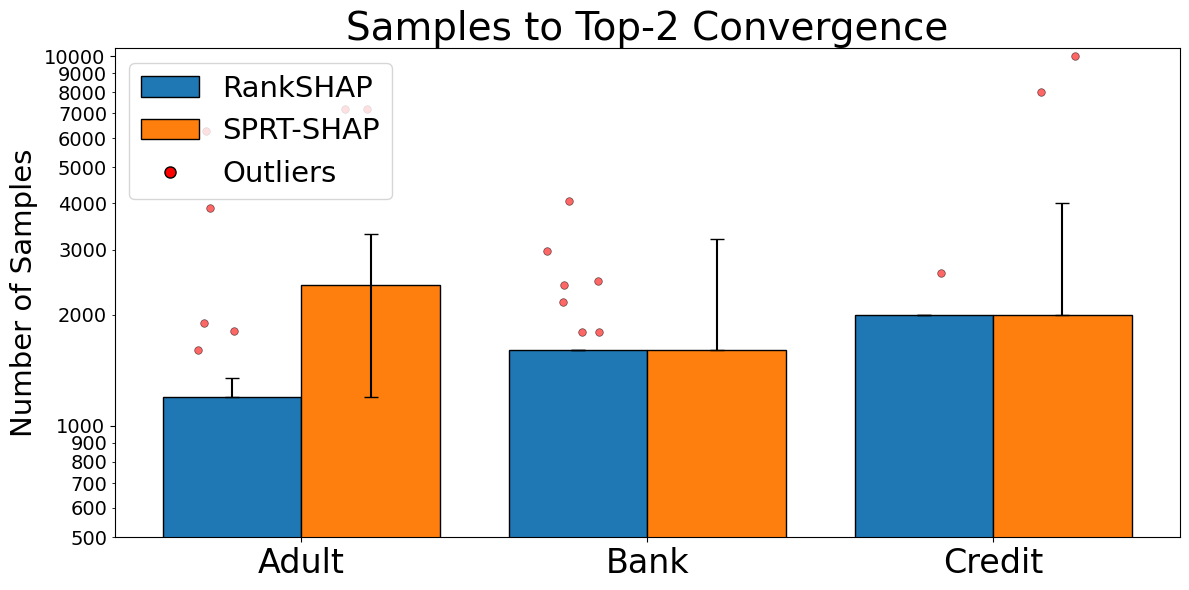

In [4]:
# ============================
# 1. Data Preparation
# ============================

# Define the number of datasets and methods
dataNames = ["Adult", "Bank", "Credit"]  # Dataset names
methodNames = ["RankSHAP", "SPRT-SHAP"]   # Method names

# Calculate median, Q1, Q3, and identify outliers for each group and method
medians = []
q1 = []
q3 = []
outliers = [[] for _ in range(N_datasets * K)]  # List of lists for outliers

for group in range(N_datasets):
    for method in range(K):
        data = N_samples_all_datasets[group, :, method]
        median = np.median(data)
        first_quartile = np.percentile(data, 25)
        third_quartile = np.percentile(data, 75)
        iqr = third_quartile - first_quartile
        lower_bound = first_quartile - 1.5 * iqr
        upper_bound = third_quartile + 1.5 * iqr
        # Identify outliers
        group_outliers = data[(data < lower_bound) | (data > upper_bound)]
        
        # Append statistics
        medians.append(median)
        q1.append(first_quartile)
        q3.append(third_quartile)
        outliers[group * K + method].extend(group_outliers)

# ============================
# 2. Define Bar Positions
# ============================

# Parameters for spacing
group_spacing = 1.5    # Space between groups
bar_width = 0.4        # Width of each bar

indices = np.arange(N_datasets)  # Group indices: [0, 1, 2]
offset = np.array([-bar_width/2, bar_width/2])  # Offsets for the two methods

# Calculate positions for each bar
positions = []
for i in range(K):
    positions.extend(indices + offset[i])

# ============================
# 3. Reshape Data for Plotting
# ============================

# Convert lists to NumPy arrays for easier manipulation
medians = np.array(medians)
q1 = np.array(q1)
q3 = np.array(q3)

# Calculate error values relative to the median
error_lower = medians - q1
error_upper = q3 - medians
errors = [error_lower, error_upper]

# Reshape medians and errors for each method
# medians_reshaped = medians.reshape(K, N_datasets)
# error_lower_reshaped = error_lower.reshape(K, N_datasets)
# error_upper_reshaped = error_upper.reshape(K, N_datasets)
medians_reshaped = medians.reshape(N_datasets, K).T
error_lower_reshaped = error_lower.reshape(N_datasets, K).T
error_upper_reshaped = error_upper.reshape(N_datasets, K).T

# ============================
# 4. Create the Bar Plot
# ============================

fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each method
colors = ['#1f77b4', '#ff7f0e']  # Blue for RankSHAP, Orange for SPRT-SHAP

for method in range(K):
    ax.bar(
        indices + offset[method],
        medians_reshaped[method],
        width=bar_width,
        label=methodNames[method],
        color=colors[method],
        yerr=[error_lower_reshaped[method], error_upper_reshaped[method]],
        capsize=5,
        edgecolor='black'
    )

# ============================
# 5. Overlay Outliers
# ============================

for i in range(N_datasets):
    for j in range(K):
        outlier_values = outliers[i * K + j]
        if len(outlier_values) > 0:
            # Calculate the x-position for the scatter
            x = indices[i] + offset[j]
            # Add jitter to x to prevent overlap
            jitter = np.random.uniform(-bar_width/4, bar_width/4, size=len(outlier_values))
            ax.scatter(
                np.full(len(outlier_values), x) + jitter,
                outlier_values,
                color='red',
                alpha=0.6,
                edgecolor='black',
                linewidth=0.5,
                s=30,
                zorder=5  # Ensure outliers are on top
            )

# ============================
# 6. Customize Axes and Labels
# ============================

# Customize x-axis ticks to represent datasets
ax.set_xticks(indices)
ax.set_xticklabels(dataNames, fontsize=24)

# Set labels and title
ax.set_ylabel('Number of Samples', fontsize=21)
ax.set_title('Samples to Top-2 Convergence', fontsize=28)# by Method and Dataset

# Set y-axis to logarithmic scale
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.tick_params(axis='y', which='both', labelsize=14)
ax.set_ylim(bottom=500, top=10500)  # Adjust as needed based on your data

# ============================
# 7. Add Legends
# ============================

# Create custom legend elements
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label=methodNames[0]),
    Patch(facecolor=colors[1], edgecolor='black', label=methodNames[1]),
    plt.Line2D([0], [0], marker='o', color='w', label='Outliers',
               markerfacecolor='red', markeredgecolor='black', markersize=8)
]

# Add the legend to the plot
ax.legend(handles=legend_elements, fontsize=21, loc='upper left')

# ============================
# 8. Final Touches and Display
# ============================

# Improve layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.savefig(join(dir_path, "Experiments", "Figures", "num_samples_comparison.pdf"), format='pdf', dpi=300, bbox_inches='tight')#, rasterized=True
plt.show()

# RankSHAP Permutation Analysis

In [5]:
import pandas as pd
data_dir = join(dir_path, "Experiments", "Data")
X_orig = pd.read_csv(join(data_dir, "census", "census_X.csv"), index_col=0)
colnames = X_orig.columns
d = len(colnames)


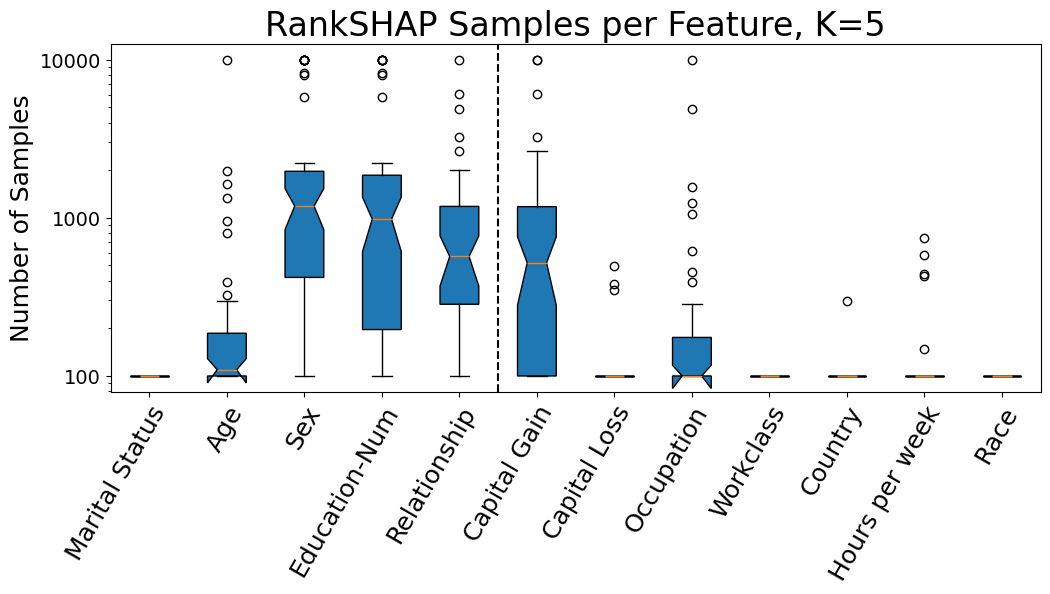

In [6]:
import pickle
alpha = 0.1
K = 5
dataset = "census"
method = "rankshap"
data_dir = join(dir_path, "Experiments", "Results", "Top_K", "rank", "alpha_"+str(alpha))
fname = method + "_" + dataset + "_K" + str(K) 
path = join(data_dir, fname)
with open(path, "rb") as fp:
    results = pickle.load(fp)

idx = 6
N_samples_all_runs = results['N_samples_per_feature'][idx]
rankshap_vals = results['shap_vals'][idx]
shap_vals = np.mean(rankshap_vals, axis=0)

# N_samples_all_runs = np.array(N_samples_all_runs)
meds = np.median(N_samples_all_runs, axis=0)
order = helper.get_ranking(shap_vals, abs=True)

plt.figure(figsize=(12,6))
c = "blue"
ordered_samples = N_samples_all_runs[:,order]
plt.boxplot(ordered_samples, showfliers=True, notch=True, patch_artist=True)
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.tick_params(axis='y', which='both', labelsize=14)


plt.xticks(np.arange(d)+1, colnames[order], rotation=60, rotation_mode='anchor', ha="right", fontsize=18)
plt.axvline(5.5, color="black", linestyle="dashed")
plt.subplots_adjust(bottom=0.3)
# plt.xlabel("Feature", size=13)
plt.ylabel("Number of Samples", size=18)
plt.title("RankSHAP Samples per Feature, K=5", size=24)
plt.savefig(join(dir_path, "Experiments", "Figures", "num_samples_rankshap.pdf"), format='pdf', dpi=300, bbox_inches='tight')
plt.show()

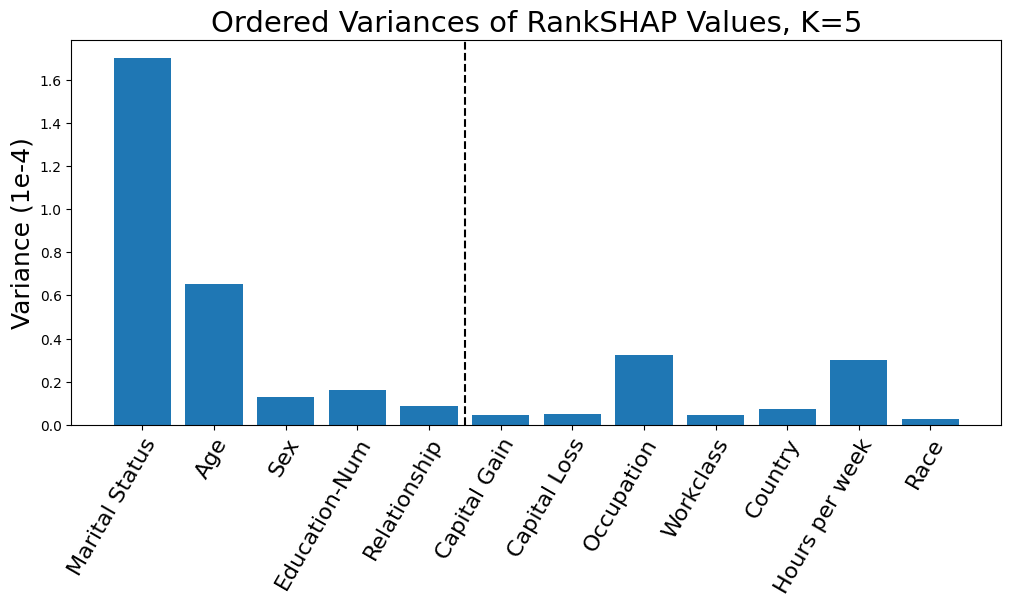

In [7]:
rankshap_vars = results['shap_vars'][idx]
shap_vars = np.mean(rankshap_vars, axis=0)[order]
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(np.arange(d)+1, shap_vars*1e4)
plt.axvline(5.5, color="black", linestyle="dashed")
ax.set_xticks(np.arange(d)+1, colnames[order], rotation=60, rotation_mode='anchor', ha="right", size=16)
# plt.xlabel("Feature", size=13)
plt.ylabel("Variance (1e-4)", size=18)
plt.title("Ordered Variances of RankSHAP Values, K=5", size=21)
plt.savefig(join(dir_path, "Experiments", "Figures", "vars_rankshap.pdf"), format='pdf', dpi=300, bbox_inches='tight')
plt.show()